# Libraries

In [ ]:
from osgeo import gdal, ogr
import os
import numpy as np
import geopandas as gpd
# gpd.options.io_engine = "pyogrio"
import pandas as pd
from shapely.geometry import box
import itertools
import re
import glob
import netCDF4
import rasterio as rio
from datetime import datetime
import numpy as np
import pandas as pd
import io
import shutil


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # default='warn'



In [ ]:
import Global_Functions
import Gdal_Functions


# Main functions

In [ ]:
def subsetBA(filehandle, bounds, format='NETCDF', lat='lat', lon='lon'):
    lat_names = ['lat', 'latitude', 'LatRows', 'y', 'Y']
    lon_names = ['lon', 'longitude', 'LonCols', 'x', 'X']
    if format == 'NETCDF':
        try:
            for i in lat_names: 
                if i in filehandle.dimensions:
                    lathandle = filehandle.variables[i]
                    break
        except:
            print('give correct lat name')
        try:
            for j in lon_names:   
                if j in filehandle.dimensions:
                    lonhandle = filehandle.variables[j]
                    break
        except:
            print('give correct lon name')  
        lat=lathandle[:]
        lon=lonhandle[:]
        
    elif format == 'HDF':
        try:
            for i in lat_names: 
                if i in filehandle.dimensions:
                    nRows = filehandle.dimensions[i].size
                    break
        except:
            print('give correct lat name')
        try:
            for j in lon_names: 
                if j in filehandle.dimensions:                
                    nCols = filehandle.dimensions[j].size
                    break
        except:
            print('give correct lon name')   
        nRows = filehandle.dimensions['LatRows'].size
        nCols = filehandle.dimensions['LonCols'].size
        xRes = 180 / nRows 
        yRes = 360 / nCols
        lat = np.linspace(90 - yRes/2, -90 + yRes/2, nRows)
        lon = np.linspace(-180 + xRes/2, 180 - xRes/2, nCols)
        
    elif format == 'profile':
        gt = filehandle['transform']
        nRows = filehandle['height']
        nCols = filehandle['width']
        xRes, yRes = gt[0], gt[4]
        x0, y0 = gt[2], gt[5]
        lat = np.arange(y0 + yRes/2, y0 + yRes/2 + nRows*yRes, yRes)
        lon = np.arange(x0 + xRes/2, x0 + xRes/2 + nCols*xRes, xRes)  

    lat_min = min(bounds[1], bounds[3])
    lat_max = max(bounds[1], bounds[3])
    lon_min = bounds[0]
    lon_max = bounds[2]  
    lat_index_range = np.argwhere((lat > lat_min) & (lat < lat_max))[:, 0]
    lon_index_range = np.argwhere((lon > lon_min) & (lon < lon_max))[:, 0]
    
    return lat_index_range,lon_index_range

def aggregateBAMT(file):
    with rio.open(file) as ras:
        arr = ras.read(1)
        area = Global_Functions.get_pixel_area(ras, path=False, rio_array=True, area_1d=True)
        np.place(arr, arr > 0, 1)
        np.place(arr, arr < 0, 0)
    area = arr.transpose() * area
    del arr
#     area = np.ma.array(area, mask=area == 0, fill_value=-1)
#     print(area.min(), area.max(), area.mean())
    return area.sum()

def get_bounds(h, v, height, width, res):
    xmin, ymax = v.min(), h.max() 
    xmax = v.max() + (width * res)
    ymin = h.min() - (height * res)
    return (xmin, ymin, xmax, ymax)

In [ ]:
180/0.25

720.0

In [ ]:
def InterCompareSFDBA(year, products, ncPath, BAMTPath, res, zone, bounds=None):
    print(year, flush=True)
    months = pd.date_range(f'{year}0101', f'{year}1201', freq='MS')
    doys = [m.strftime('%Y%j') for m in months]
    months = [m.strftime('%Y%m') for m in months]
    if not bounds:
        driver = ogr.GetDriverByName('ESRI Shapefile')
        shpObject = driver.Open(f'{BAMTPath}/Regions/{zone}.shp', 1)
        bounds = [shpObject.GetLayer().GetExtent()[i] for i in (0, 2, 1, 3)]
    n0 = -1
    n = -1
    dims = int(abs(bounds[2] - bounds[0]) / res), int(abs(bounds[3] - bounds[1]) / res)
    area = np.full(shape=(len(products), dims[0]*dims[1]), fill_value=0, dtype=np.float32)
    gt = rio.Affine.translation(bounds[0], bounds[3]) * rio.Affine.scale(res, -res)
    p = dict(transform=gt, height=dims[1], width=dims[0])
    cell_area = Global_Functions.get_pixel_area(p, path=False, profile=True).flatten()
    if 'FireCCISFDL' in products:
        naming = f'BA_Area_{str(res).replace(".", "")}D_{year}.tif'
        n0 = -1
        n += 1
        with rio.open(f'{BAMTPath}/{zone}/Summaries/{naming}') as src:
            arr = src.read(1)
            profile = src.profile
        subset = subsetBA(profile, bounds, format='profile')
    #     print(arr[subset[0]][:, subset[1]].shape, subset[1].shape)
        arr = arr[subset[0]][:, subset[1]].flatten()
        area[n] = arr   
        # cell_area = Global_Functions.get_pixel_area(f'{BAMTPath}/{zone}/Summaries/{naming}').flatten()
    for i, m in enumerate(months):
        n = n0
        if 'C3SBA11' in products:
            try:
                file_C3S = glob.glob(f'{ncPath}/C3SBA11/{m}01-C3S-L4_FIRE-BA-OLCI-fv1.[0-1].nc')[0]
                n += 1 
                with netCDF4.Dataset(file_C3S, 'r') as nc:
                    arr = nc.variables['burned_area']
                    subset = subsetBA(nc, bounds, format='NETCDF')
                    area[n] += arr[0, subset[0], subset[1]].flatten()
            except:
                print(f'C3SBA11 unavailable for {m}')
        if 'FireCCI51' in products:
            try:
                file_51 = f'{ncPath}/FireCCI51/{m}01-ESACCI-L4_FIRE-BA-MODIS-fv5.1.nc'
                n += 1 
                with netCDF4.Dataset(file_51, 'r') as nc:
                    arr = nc.variables['burned_area']
                    subset = subsetBA(nc, bounds, format='NETCDF')
                    area[n] += arr[0, subset[0], subset[1]].flatten()
            except:
                print(f'FireCCI51 unavailable for {m}')
        if 'MCD64A1' in products:
            # try:
                file_MCD64A1 = glob.glob(f'{ncPath}/MCD64A1/MCD64CMQ.A{doys[i]}.0[0-6][1-6].*.hdf')[0]
                n += 1 
                print(n, 'MCD64A1')
                with netCDF4.Dataset(file_MCD64A1, 'r') as nc:
                    arr = nc.variables['BurnedArea']
                    subset = subsetBA(nc, bounds, format='HDF')
                    area[n] += (arr[subset] * 1e4).flatten()
            # except:
            #     print(f'MCD64A1 unavailable for {m}')  
        if 'FireCCIS311' in products:
            try:
                file_S3 = f'{ncPath}/FireCCIS311/{m}01-ESACCI-L4_FIRE-BA-SYN-fv1.1.nc'
                n += 1 
                with netCDF4.Dataset(file_S3, 'r') as nc:
                    arr = nc.variables['burned_area']
                    subset = subsetBA(nc, bounds, format='NETCDF')
                    area[n] += arr[0, subset[0], subset[1]].flatten()
            except:
                print(f'FireCCIS311 unavailable for {m}')   

        if 'FireCCIS2' in products:
            try:
                file_S2 = glob.glob(f'{ncPath}/FireCCIS2/{m}01-ESACCI-L4_FIRE-BA-MSI-fv1.0.[0-9].nc')[0]
                n += 1 
                with netCDF4.Dataset(file_S2, 'r') as nc:
                    arr = nc.variables['burned_area'][0]
                    if res == 0.25:
                        scale = int(0.25/0.05)     
                        arr = arr.reshape(arr.shape[0] // scale, scale, 
                                    arr.shape[1] // scale, scale).sum(axis=(1, 3))
                    area[n] += arr.flatten()
            except:
                print(f'FireCCIS2 unavailable for {m}') 
                
    if 'FireCCISFDS2' in products:
        try:
            file_S2 = f'FireCCISFD_S2_BA_Area_005_{year}.tif'
            n += 1 
            with rio.open(f'{BAMTPath}/{zone}/Summaries/{file_S2}') as src:
                arr = src.read(1)
                if res == 0.25:
                    scale = int(0.25/0.05)
                    arr = arr.reshape(arr.shape[0] // scale, scale, 
                                arr.shape[1] // scale, scale).sum(axis=(1, 3))
            area[n] = np.array(arr.flatten())   
        except:
            print(f'FireCCISFDS2 unavailable for {year}')   

    if 'GFED4s' in products:
        try:
            file_GFED4s = f'GFED4s_ALL-BA_025D_{year}.tif'
            n += 1
            with rio.open(f'{BAMTPath}/{zone}/PeatFire/Summaries/{file_GFED4s}') as src:
                arr = src.read(1)
            subset = subsetBA(profile, bounds, format='profile')
            arr = arr[subset[0]][:, subset[1]].flatten()
            area[n] = np.array(arr.flatten())   
        except:
            print(f'GFED4s unavailable for {year}')

    if 'GFED500' in products:
        try:
            file_GFED500 = f'GFED500_ALL-BA_025D_{year}.tif'
            n += 1
            with rio.open(f'{BAMTPath}/{zone}/PeatFire/Summaries/{file_GFED500}') as src:
                arr = src.read(1)
            subset = subsetBA(profile, bounds, format='profile')
            arr = arr[subset[0]][:, subset[1]].flatten()
            area[n] = np.array(arr.flatten())   
        except:
            print(f'GFED500 unavailable for {year}')
    
    for i in range(1, n+1):
        if area[i].sum() == 0:
            area[i] = np.nan
    return area, cell_area

# All Siberia 

In [ ]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA'
compPath = '/media/amin/DISK6T/PhD/Landsat_BA/Comparisons'
ncPath = '/media/amin/STORAGE/STORAGE/OneDrive/PhD/FireCCI_C3S/C3S_BA_Tests'
zone, dataset = 'Siberia', 'Lndst'
ESACCI=False; UTM=False; res = 0.25
Years = range(2001, 2024, 1)
products = ['FireCCISFDL', 'C3SBA11', 'FireCCI51', 'MCD64A1', 'FireCCIS311', 'GFED4s', 'GFED500']
# ds = Parallel(n_jobs=18, verbose=100, backend='threading') (delayed (InterCompareSFDBA) (
#                 year, products, ncPath, local_path, res, zone, dataset) for year in Years[:])
bounds = [63, 58, 180, 74]
ds = []
for year in Years:
    areas, _ = InterCompareSFDBA(year, products, ncPath, local_path, res, zone, dataset, bounds)
    ds.append(np.expand_dims(areas, axis=0))

data = np.concatenate(ds, axis=0)
df = pd.DataFrame(data.sum(axis=2), columns=products, index=Years)
df.to_csv(f'{compPath}/{zone}{"_ESACCI" * ESACCI}_Intercomparison_{Years[0]}-{Years[-1]}.csv')

2001
C3SBA11 unavailable for 200101
FireCCIS311 unavailable for 200101
C3SBA11 unavailable for 200102
FireCCIS311 unavailable for 200102
C3SBA11 unavailable for 200103
FireCCIS311 unavailable for 200103
C3SBA11 unavailable for 200104
FireCCIS311 unavailable for 200104
C3SBA11 unavailable for 200105
FireCCIS311 unavailable for 200105
C3SBA11 unavailable for 200106
FireCCIS311 unavailable for 200106
C3SBA11 unavailable for 200107
FireCCIS311 unavailable for 200107
C3SBA11 unavailable for 200108
FireCCIS311 unavailable for 200108
C3SBA11 unavailable for 200109
FireCCIS311 unavailable for 200109
C3SBA11 unavailable for 200110
FireCCIS311 unavailable for 200110
C3SBA11 unavailable for 200111
FireCCIS311 unavailable for 200111
C3SBA11 unavailable for 200112
FireCCIS311 unavailable for 200112
GFED500 unavailable for 2001
2002
C3SBA11 unavailable for 200201
FireCCIS311 unavailable for 200201
C3SBA11 unavailable for 200202
FireCCIS311 unavailable for 200202
C3SBA11 unavailable for 200203
FireCC

# Arctic 

In [ ]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA'
compPath = '/media/amin/DISK6T/PhD/Landsat_BA/Comparisons'
ncPath = '/media/amin/STORAGE/STORAGE/OneDrive/PhD/FireCCI_C3S/C3S_BA_Tests'
zone, dataset = 'Siberia', 'Lndst'
ESACCI=False; UTM=False; res = 0.25
Years = range(2001, 2024, 1)
products = ['FireCCISFDL', 'C3SBA11', 'FireCCI51', 'MCD64A1', 'FireCCIS311', 'GFED4s', 'GFED500']
# ds = Parallel(n_jobs=18, verbose=100, backend='threading') (delayed (InterCompareSFDBA) (
#                 year, products, ncPath, local_path, res, zone, dataset) for year in Years[:])
bounds = [72.3, 66.5, 180, 74]
ds = []
for year in Years:
    areas, _ = InterCompareSFDBA(year, products, ncPath, local_path, res, zone, dataset, bounds)
    ds.append(np.expand_dims(areas, axis=0))

2001
C3SBA11 unavailable for 200101
FireCCIS311 unavailable for 200101
C3SBA11 unavailable for 200102
FireCCIS311 unavailable for 200102
C3SBA11 unavailable for 200103
FireCCIS311 unavailable for 200103
C3SBA11 unavailable for 200104
FireCCIS311 unavailable for 200104
C3SBA11 unavailable for 200105
FireCCIS311 unavailable for 200105
C3SBA11 unavailable for 200106
FireCCIS311 unavailable for 200106
C3SBA11 unavailable for 200107
FireCCIS311 unavailable for 200107
C3SBA11 unavailable for 200108
FireCCIS311 unavailable for 200108
C3SBA11 unavailable for 200109
FireCCIS311 unavailable for 200109
C3SBA11 unavailable for 200110
FireCCIS311 unavailable for 200110
C3SBA11 unavailable for 200111
FireCCIS311 unavailable for 200111
C3SBA11 unavailable for 200112
FireCCIS311 unavailable for 200112
GFED500 unavailable for 2001
2002
C3SBA11 unavailable for 200201
FireCCIS311 unavailable for 200201
C3SBA11 unavailable for 200202
FireCCIS311 unavailable for 200202
C3SBA11 unavailable for 200203
FireCC

In [ ]:
data = np.concatenate(ds, axis=0)
df = pd.DataFrame(data.sum(axis=2), columns=products, index=Years)
df['Descals'] = pd.read_csv('/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/ArcticFires-Descals-2022-v1.1/main/DATA/ARCTIC_TRENDS_merged_v3-3.csv', index_col='year').BA * 1e10
df.to_csv(f'{compPath}/{zone}{"_ESACCI" * ESACCI}_Intercomparison_Arctic_{Years[0]}-{Years[-1]}.csv')

In [ ]:
df

,FireCCISFDL,C3SBA11,FireCCI51,MCD64A1,FireCCIS311,GFED4s,GFED500,Descals
2001,1.646745e+10,NaN,1.147866e+10,1.000204e+10,NaN,1.198741e+10,NaN,9.925182e+09
2002,2.611385e+09,NaN,1.247220e+09,1.055939e+09,NaN,1.014729e+09,1.169690e+09,1.059575e+09
2003,5.976940e+09,NaN,4.375441e+09,4.138865e+09,NaN,3.147794e+09,4.440551e+09,3.892501e+09
2004,4.023764e+08,NaN,2.385394e+08,1.359046e+08,NaN,1.788444e+08,1.491041e+08,1.822775e+08
2005,5.803607e+09,NaN,3.141530e+09,2.213054e+09,NaN,2.893547e+09,2.515976e+09,2.716167e+09
2006,1.545578e+09,NaN,8.123220e+08,7.440458e+08,NaN,8.749505e+08,8.319054e+08,7.314631e+08
2007,1.099450e+09,NaN,6.749941e+08,4.941005e+08,NaN,5.113602e+08,5.325982e+08,5.726406e+08
2008,2.632512e+08,NaN,3.844537e+08,4.673055e+08,NaN,3.592410e+09,4.843837e+08,2.395951e+08
2009,2.222599e+09,NaN,1.063526e+09,9.103884e+08,NaN,5.634252e+08,1.032244e+09,8.958185e+08
2010,2.447343e+09,NaN,1.913682e+09,1.425281e+09,NaN,1.529522e+09,1.659054e+09,1.616997e+09


# Validation

In [ ]:
TSAs = gpd.read_file('/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/Siberia_Landsat_TSAs/Siberia_Landsat_TSAs.shp')
TSAs

,PATH,ROW,WRSP,area_m2,land_m2,ecoregion,PROJ,Samples,NBR,TILE,transform,geometry
0,129,20,129020,1.447702e+10,1.437886e+10,Boreal Forest,EPSG:32650,NaN,126,60N114E,"[0.00025, 0, 114.0, 0, -0.00025, 60.0]","POLYGON ((6734011.962 6455759.590, 6797436.660..."
1,146,20,146020,1.447729e+10,1.447066e+10,Boreal Forest,EPSG:32645,NaN,57,60N087E,"[0.00025, 0, 87.0, 0, -0.00025, 60.0]","POLYGON ((5190360.718 6455760.061, 5244272.570..."
2,154,20,154020,1.447696e+10,1.447563e+10,Boreal Forest,EPSG:32643,NaN,29,60N075E,"[0.00025, 0, 75.0, 0, -0.00025, 60.0]","POLYGON ((4463932.486 6455760.061, 4513365.843..."
3,162,20,162020,1.447696e+10,1.443732e+10,Boreal Forest,EPSG:32641,NaN,3,60N063E,"[0.00025, 0, 63.0, 0, -0.00025, 60.0]","POLYGON ((3737504.254 6455760.061, 3782459.128..."
4,113,20,113020,1.447719e+10,7.857908e+09,Boreal Forest,EPSG:32654,NaN,182,60N138E,"[0.00025, 0, 138.0, 0, -0.00025, 60.0]","POLYGON ((8186868.598 6455759.590, 8259250.090..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2106,115,9,115009,7.515463e+09,1.995304e+07,Tundra,EPSG:32656,130,208,72N150E,"[0.00025, 0, 150.0, 0, -0.00025, 72.0]","POLYGON ((5295417.363 7967011.014, 5397354.935..."
2107,125,9,125009,7.514990e+09,4.473453e+08,Tundra,EPSG:32653,NaN,167,74N132E,"[0.00025, 0, 132.0, 0, -0.00025, 74.0]","POLYGON ((4495375.212 8059326.362, 4463321.614..."
2108,125,9,125009,7.514990e+09,4.473453e+08,Tundra,EPSG:32653,NaN,166,72N132E,"[0.00025, 0, 132.0, 0, -0.00025, 72.0]","POLYGON ((4701902.502 7967016.853, 4645717.424..."
2109,125,9,125009,7.514990e+09,4.473453e+08,Tundra,EPSG:32653,NaN,167,74N135E,"[0.00025, 0, 135.0, 0, -0.00025, 74.0]","POLYGON ((4546958.043 8059326.362, 4699025.378..."


In [ ]:
list_TSAs = TSAs.WRSP.unique()
folders = glob.glob('/home/amin/firecci/0_Final_Products/Reference_Perimeters/*_global_2023/shapefiles/*')
Years = np.unique([i.split('/')[-1] for i in folders])
TSAs_Year = pd.DataFrame({'TSA': [], 'Year': [], 'Period': []})
[TSAs_Year.update({year: {}}) for year in Years]
for t in list_TSAs:
    for f in folders:
        for i in glob.glob(f'{f}/*.shp'):
            iden = os.path.basename(i).split('_')[2]
            year = os.path.basename(i).split('_')[4][:4]
            period = i[-21:-4]
            if t == iden:
                new_row = pd.Series({'TSA': t, 'Year': year, 'Period': period})
                TSAs_Year = pd.concat([TSAs_Year, new_row.to_frame().T], ignore_index=True)
                for ext in ['dbf', 'prj', 'shp', 'shp.xml', 'sbx', 'sbn', 'shx']:
                    shutil.copy2(f'{i[:-4]}.{ext}', 
                        f'/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/{os.path.basename(i)[:-4]}.{ext}')
                

In [ ]:
list(glob.glob('/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/*[!E,84].shp'))

['/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/C3S_RD_162017_20220607_20220802.shp',
 '/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/C3S_RD_093015_20170101_20171230.shp',
 '/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/FireCCI_RD_136019_20060715_20060731.shp',
 '/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/FireCCI_RD_103014_20130711_20130719.shp',
 '/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/FireCCI_RD_117018_20100814_20100822.shp',
 '/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/FireCCI_RD_132020_20110919_20110927.shp',
 '/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/FireCCI_CNR_155013_20190227_20190727.shp',
 '/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/FireCCI_RD_125019_20080629_20080707.shp',
 '/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/FireCCI_CNR_151016_20070719_20070921.shp',
 '/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/FireCCI_CNR_155015_20190430_20190823.s

In [ ]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA/Siberia'
grid = gpd.read_file('/media/amin/DISK6T/PhD/Landsat_BA/Regions/Tiles_Siberia_3dLon.shp')
bins_x = np.arange(63, 180, 3)
bins_y = np.arange(74, 58, -2)
for j, shp in enumerate(list(glob.glob('/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/*[!E,84].shp'))[:]):
    print(j, os.path.basename(shp))
    gdf = gpd.read_file(shp).to_crs(grid.crs).query("category in ['1', '3']")
    if '1' in gdf.category.unique():
        print('### Added')
        xmin, ymin, xmax, ymax = gdf.total_bounds
        xmin, xmax = (bins_x[np.digitize(i, bins_x)-1] for i in [xmin, xmax])
        ymin, ymax = (bins_y[np.digitize(i, bins_y)-1] for i in [ymin, ymax])
        points = tuple(itertools.product([xmin, xmax], [ymin, ymax]))
        gdf['JD_pre'] = [datetime.strptime(i, '%Y-%m-%d').timetuple().tm_yday for i in gdf.preDate]
        gdf['JD_post'] = [datetime.strptime(i, '%Y-%m-%d').timetuple().tm_yday for i in gdf.postDate]
        gdf.to_file(f'{shp[:-4]}_WGS84.shp')
        for coords in points:
            intersection = gpd.overlay(gdf, gpd.GeoDataFrame(geometry=[box(coords[0], coords[1]-2, coords[0]+3, coords[1])], crs="EPSG:4326"), 
                         how='intersection')
            if len(intersection) > 0:
                tile = f'TILE-{coords[1]:02}N{coords[0]:03}E'
                print(f'+++ {tile}')
                ref = gdal.Open(f'{local_path}/ByTile/{tile}/Enhanced/Yearly/BAMT_BA_Siberia_Lndst_{year}_{tile}_JD_Correct_Patches.tif')
                args = dict(gt = ref.GetGeoTransform(),
                            Xsize = ref.GetRasterBand(1).XSize,
                            Ysize = ref.GetRasterBand(1).YSize,
                            allTouched=False
                           )
                intersection.to_file(f'{shp[:-4]}_{tile}.shp')
                Gdal_Functions.rasterize_gdal(f'{shp[:-4]}_{tile}.shp',
                    f'{local_path}/Validation/{os.path.basename(shp)[:-4]}_{tile}_Category.tif',
                        attribute='category', dtype=gdal.GDT_Byte, **args)
                Gdal_Functions.rasterize_gdal(f'{shp[:-4]}_{tile}.shp',
                    f'{local_path}/Validation/{os.path.basename(shp)[:-4]}_{tile}_JD_pre.tif',
                        attribute='JD_pre', dtype=gdal.GDT_Int16, **args)
                Gdal_Functions.rasterize_gdal(f'{shp[:-4]}_{tile}.shp',
                    f'{local_path}/Validation/{os.path.basename(shp)[:-4]}_{tile}_JD_post.tif',
                        attribute='JD_post', dtype=gdal.GDT_Int16, **args)

0 FireCCI_CNR_155013_20190227_20190727.shp
1 FireCCI_CNR_151016_20070719_20070921.shp
### Added
+++ TILE-64N171E
+++ TILE-64N171E
+++ TILE-64N171E
+++ TILE-64N171E
2 FireCCI_CNR_155015_20190430_20190823.shp
### Added
+++ TILE-64N171E
+++ TILE-64N171E
+++ TILE-64N171E
+++ TILE-64N171E
3 FireCCI_CNR_153014_20160623_20160826.shp
### Added
+++ TILE-64N171E
+++ TILE-64N171E
+++ TILE-64N171E
+++ TILE-64N171E
4 FireCCI_CNR_154014_20160427_20160716.shp


/tmp/ipykernel_339651/1422807106.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '1' in gdf.category.unique():
/tmp/ipykernel_339651/1422807106.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '1' in gdf.category.unique():


5 FireCCI_CNR_155016_20180408_20180713.shp
6 FireCCI_CNR_157016_20160619_20160822.shp


/tmp/ipykernel_339651/1422807106.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '1' in gdf.category.unique():


7 FireCCI_CNR_151016_20160609_20160812.shp
### Added
+++ TILE-64N171E
+++ TILE-64N171E
+++ TILE-64N171E
+++ TILE-64N171E
8 FireCCI_CNR_156011_20190220_20190814.shp


In [ ]:
shp = list(glob.glob('/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/*.shp'))[0]
a = gpd.read_file(shp)
grid = gpd.read_file('/media/amin/DISK6T/PhD/Landsat_BA/Regions/Tiles_Siberia_3dLon.shp')

<AxesSubplot: >

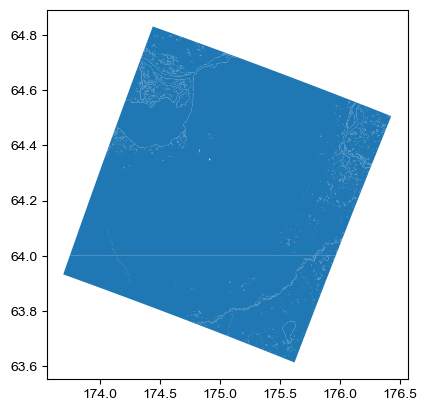

In [ ]:
gpd.overlay(grid, a.to_crs(grid.crs), how='intersection').plot()

In [ ]:
TSAs_Year.sort_values('Year', ascending=False)

,TSA,Year,Period
0,116018,2021,20210704_20210906
2,116015,2021,20210618_20210922
29,121016,2021,20210605_20210909
28,100015,2021,20210501_20210906
1,107011,2021,20210502_20210705
23,111016,2021,20210223_20210428
22,116017,2021,20210704_20210906
15,136017,2020,20200220_20200814
41,112013,2020,20200212_20200806
31,095017,2020,20200611_20200830


In [ ]:
pd.date_range('20190401', '20190601', freq='MS', inclusive='both')

DatetimeIndex(['2019-04-01', '2019-05-01', '2019-06-01'], dtype='datetime64[ns]', freq='MS')

In [ ]:
def get_metrics(tile, shp, local_path, logfile=None):
    if not logfile:
        logfile = io.StringIO()
    Global_Functions.print_and_log(logfile, f'\n\t\t{15 * "-"} {os.path.basename(shp)[:-4]}_{tile} {15 * "-"}')  

    year = os.path.basename(shp).split('_')[4][:4]
    with rio.open(f'{local_path}/ByTile/{tile}/Enhanced/Yearly/BAMT_BA_Siberia_Lndst_{year}_{tile}_JD_Correct_Patches.tif') as src:
        BA = src.read(1)    
    with rio.open(f'{local_path}/Validation/{os.path.basename(shp)[:-4]}_{tile}_JD_post.tif') as src:
        postJD = src.read(1)
    with rio.open(f'{local_path}/Validation/{os.path.basename(shp)[:-4]}_{tile}_JD_pre.tif') as src:
        preJD = src.read(1)  
    with rio.open(f'{local_path}/Validation/{os.path.basename(shp)[:-4]}_{tile}_Category.tif') as src:
        label = src.read(1)    
    preJD[(preJD >= postJD) & (preJD > 0)] = 1
    BA[(BA > 0) & (BA > postJD) & (BA < preJD)] = -1   

    tp = np.count_nonzero((BA > 0) & (label == 1))
    fp = np.count_nonzero((BA > 0) & (label == 3))
    tn = np.count_nonzero((BA == 0) & (label == 3))
    fn = np.count_nonzero((BA == 0) & (label == 1))
    try:
        dice = 2 * tp / ((2 * tp) + fn + fp)
        oe = 100 * fn / (fn + tp) 
        ce = 100 * fp / (fp + tp)
        Global_Functions.print_and_log(logfile, f'\t\t+++Ce is {ce:0.4}% , Oe is {oe:0.4}% and Dice Coef is {dice:0.2}')
    except:
        pass
    return tp, fp, fn, tn

In [ ]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA/Siberia'
get_metrics('TILE-64N138E', 'C3S_RD_116015_20210618_20210922.shp', local_path, logfile=None)


		--------------- C3S_RD_116015_20210618_20210922_TILE-64N138E ---------------
		+++Ce is 22.49% , Oe is 2.593% and Dice Coef is 0.86


(167199, 48503, 4451, 5067388)

In [ ]:
ls = []
for i in glob.glob(f'{local_path}/Validation/*_Category.tif'):
    tile = i.split('_')[-2]
    TSA = i.split('_TILE')[0] + '.shp'
    ls.append(get_metrics(tile, TSA, local_path, logfile=None))
    


		--------------- C3S_RD_140019_20190504_20190909_TILE-60N099E ---------------
		+++Ce is 40.29% , Oe is 0.03332% and Dice Coef is 0.75

		--------------- C3S_RD_153011_20170712_20170829_TILE-70N087E ---------------
		+++Ce is 50.07% , Oe is 24.95% and Dice Coef is 0.6

		--------------- C3S_RD_123013_20190206_20191004_TILE-68N129E ---------------
		+++Ce is 29.67% , Oe is 1.518% and Dice Coef is 0.82

		--------------- FireCCI_RD_115019_20080717_20080818_TILE-60N135E ---------------
		+++Ce is 75.25% , Oe is 0.7095% and Dice Coef is 0.4

		--------------- C3S_RD_095014_20190321_20190929_TILE-68N174E ---------------

		--------------- C3S_RD_158015_20190126_20190822_TILE-66N075E ---------------
		+++Ce is 33.44% , Oe is 26.33% and Dice Coef is 0.7

		--------------- C3S_RD_117015_20180124_20180820_TILE-64N135E ---------------
		+++Ce is 30.06% , Oe is 3.389% and Dice Coef is 0.81

		--------------- C3S_RD_095017_20200611_20200830_TILE-62N168E ---------------
		+++Ce is 39.12% , Oe is 

In [ ]:
tp, fp, fn, tn = np.array(ls).sum(0)
dice = 2 * tp / ((2 * tp) + fn + fp)
oe = 100 * fn / (fn + tp) 
ce = 100 * fp / (fp + tp)
bias = (fp - fn) / (tp + fp)
(tp + fn) * 30 * 15 * 1e-6, ce, oe, dice, bias

(8075.1249,
 29.4569867236644,
 10.414516312930342,
 0.7893198381232729,
 0.21256200923412055)

In [ ]:
ls_Tiles = []
for i in glob.glob(f'{local_path}/Validation/*_Category.tif'):
    if i.split('_')[-2] not in ls_Tiles:
        ls_Tiles.append(i.split('_')[-2])

In [ ]:
len(ls_Tiles)

41

In [ ]:
def get_F51_metrics(tile, shp, local_path, logfile=None):
    if not logfile:
        logfile = io.StringIO()
    Global_Functions.print_and_log(logfile, f'\n\t\t{15 * "-"} {os.path.basename(shp)[:-4]}_{tile} {15 * "-"}')  

    year = os.path.basename(shp).split('_')[4][:4]
    if int(year) < 2023:
        with rio.open(f'{local_path}/Validation/{os.path.basename(shp)[:-4]}_{tile}_JD_post.tif') as src:
            postJD = src.read(1)
            profile = src.profile
        with rio.open(f'{local_path}/Validation/{os.path.basename(shp)[:-4]}_{tile}_JD_pre.tif') as src:
            preJD = src.read(1)  
        with rio.open(f'{local_path}/Validation/{os.path.basename(shp)[:-4]}_{tile}_Category.tif') as src:
            label = src.read(1)    
        preJD[(preJD >= postJD) & (preJD > 0)] = 1   
        
        date_rng = pd.date_range(f"{shp[:-4].split('_')[-2][:-2]}01", f"{shp[:-4].split('_')[-1][:-2]}01", 
                                 inclusive='both', freq='MS')
        Months = [i.strftime('%Y%m%d') for i in date_rng]
        for i, m in enumerate(Months):
            ds = Global_Functions.resample_by_ref(f'{local_path}/Data/FireCCI51/{m}-ESACCI-L3S_FIRE-BA-MODIS-AREA_4-fv5.1-JD.tif', 
                                            f'/vsimem/FireCCI51_{m}.tif', profile=profile, memory=True)
            if i == 0:
                BA = ds.GetRasterBand(1).ReadAsArray()
                BA[(BA > 0) & (BA > postJD) & (BA < preJD)] = -1
            else:
                new = ds.GetRasterBand(1).ReadAsArray()
                new[(new > 0) & (new > postJD) & (new < preJD)] = -1
                BA = np.max(np.array([BA, new]), axis=0)
                
        FireCCI51_path = f'{local_path}/Validation/FireCCI51_{year}_{tile}_JD.tif'
        Global_Functions.write_rasterio(BA, FireCCI51_path, profile=profile)
    
        tp = np.count_nonzero((BA > 0) & (label == 1))
        fp = np.count_nonzero((BA > 0) & (label == 3))
        tn = np.count_nonzero((BA == 0) & (label == 3))
        fn = np.count_nonzero((BA == 0) & (label == 1))
        try:
            dice = 2 * tp / ((2 * tp) + fn + fp)
            oe = 100 * fn / (fn + tp) 
            ce = 100 * fp / (fp + tp)
            Global_Functions.print_and_log(logfile, f'\t\t+++Ce is {ce:0.4}% , Oe is {oe:0.4}% and Dice Coef is {dice:0.2}')
        except:
            pass
        return tp, fp, fn, tn
    else:
        return 0, 0, 0, 0
     

In [ ]:
get_F51_metrics('TILE-66N084E', 'FireCCI_CNR_153014_20160623_20160826.shp', local_path, logfile=None)


		--------------- FireCCI_CNR_153014_20160623_20160826_TILE-66N084E ---------------
		+++Ce is 0.0% , Oe is 13.92% and Dice Coef is 0.93


(88167, 0, 14257, 0)

In [ ]:
ls = []
for i in glob.glob(f'{local_path}/Validation/*_Category.tif'):
    tile = i.split('_')[-2]
    TSA = i.split('_TILE')[0] + '.shp'
    ls.append(get_F51_metrics(tile, TSA, local_path, logfile=None))


		--------------- C3S_RD_140019_20190504_20190909_TILE-60N099E ---------------
		+++Ce is 14.49% , Oe is 16.6% and Dice Coef is 0.84

		--------------- C3S_RD_153011_20170712_20170829_TILE-70N087E ---------------
		+++Ce is 28.97% , Oe is 65.23% and Dice Coef is 0.47

		--------------- C3S_RD_123013_20190206_20191004_TILE-68N129E ---------------
		+++Ce is 27.78% , Oe is 22.3% and Dice Coef is 0.75

		--------------- FireCCI_RD_115019_20080717_20080818_TILE-60N135E ---------------
		+++Ce is 56.33% , Oe is 47.36% and Dice Coef is 0.48

		--------------- C3S_RD_095014_20190321_20190929_TILE-68N174E ---------------

		--------------- C3S_RD_158015_20190126_20190822_TILE-66N075E ---------------
		+++Ce is 18.47% , Oe is 21.82% and Dice Coef is 0.8

		--------------- C3S_RD_117015_20180124_20180820_TILE-64N135E ---------------
		+++Ce is 12.91% , Oe is 21.17% and Dice Coef is 0.83

		--------------- C3S_RD_095017_20200611_20200830_TILE-62N168E ---------------
		+++Ce is 31.58% , Oe is 46.

In [ ]:
a = []
for i in ls:
    if i:
        a.append(i)
a

[(22526, 3817, 4484, 3426087),
 (9426, 3844, 17685, 25681056),
 (1529960, 588504, 439099, 23869530),
 (11453, 14776, 10306, 8681509),
 (0, 0, 0, 162616),
 (13113, 2971, 3660, 6434298),
 (30451, 4515, 8176, 3294289),
 (45797, 21140, 40307, 25598740),
 (311918, 388991, 76514, 21371723),
 (5985, 21267, 2824, 3187951),
 (0, 0, 1992, 10223480),
 (0, 0, 0, 54458),
 (0, 0, 0, 600238),
 (15821, 0, 6012, 0),
 (246882, 201587, 237862, 23818836),
 (48079, 8333, 55139, 26821634),
 (0, 0, 0, 3197138),
 (577807, 343659, 49147, 15780908),
 (0, 0, 0, 2083428),
 (1198987, 236334, 362857, 18796062),
 (674773, 370559, 163833, 21996197),
 (78467, 44646, 22890, 19735641),
 (47004, 13305, 8175, 28363461),
 (156789, 103140, 14027, 4856964),
 (678348, 42613, 1146331, 29255016),
 (0, 0, 0, 1089656),
 (226166, 75858, 37969, 5874153),
 (1626, 4425, 5037, 9219066),
 (183, 4221, 401, 4987591),
 (6437, 0, 13558, 0),
 (62465, 7675, 8638, 1207778),
 (180, 60548, 0, 138100),
 (64829, 20517, 5016, 1118372),
 (931382, 6

In [ ]:
tp, fp, fn, tn = np.array(ls).sum(0)
dice = 2 * tp / ((2 * tp) + fn + fp)
oe = 100 * fn / (fn + tp) 
ce = 100 * fp / (fp + tp)
(tp + fn) * 30 * 15 * 1e-6, ce, oe, dice

(7254.73215, 26.52512010854825, 27.877682568887124, 0.7279231617356016)

In [ ]:
grid = gpd.read_file('/media/amin/DISK6T/PhD/Landsat_BA/Regions/Tiles_Siberia_3dLon.shp')
modis_grid = gpd.read_file('/media/amin/STORAGE/STORAGE/OneDrive/PhD/Tilling_Grids/modis_sinusoidal_grid_world.shp').to_crs("EPSG:4326")
modis_tiles = gpd.overlay(modis_grid, gpd.GeoDataFrame(geometry=[box(63, 58, 180, 74)], crs="EPSG:4326"), 
             how='intersection')
modis_tiles

,h,v,tilename,landtile,geom,geometry
0,19,1,h19v01,1,NaN,"POLYGON ((71.68687 73.80000, 70.83621 73.60000..."
1,20,1,h20v01,1,NaN,"POLYGON ((107.53031 73.80000, 106.25432 73.600..."
2,20,2,h20v02,1,NaN,"POLYGON ((63.15418 70.00000, 63.73894 70.00000..."
3,21,1,h21v01,1,NaN,"POLYGON ((143.37375 73.80000, 141.67243 73.600..."
4,21,2,h21v02,1,NaN,"POLYGON ((88.29889 70.00000, 88.88365 70.00000..."
5,21,3,h21v03,1,NaN,"POLYGON ((63.20000 60.00000, 63.60000 60.00000..."
6,22,1,h22v01,1,NaN,"POLYGON ((179.21718 73.80000, 177.09054 73.600..."
7,22,2,h22v02,1,NaN,"POLYGON ((117.53694 70.00000, 118.12170 70.000..."
8,22,3,h22v03,1,NaN,"POLYGON ((80.40000 60.00000, 80.80000 60.00000..."
9,23,1,h23v01,1,NaN,"POLYGON ((180.00000 73.80000, 180.00000 73.600..."


In [ ]:
import paramiko
ftp_Server_host = 'fuoco.geog.umd.edu'
ftp_username ='fire'
ftp_password = 'burnt'
ftp_path = '/data/MODIS/C61/MCD64A1/HDF'

transport = paramiko.Transport((ftp_Server_host, 22))
transport.connect(username = ftp_username, password = ftp_password)
sftp = paramiko.SFTPClient.from_transport(transport)

/home/amin/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [ ]:
for j, shp in enumerate(list(glob.glob('/media/amin/DISK6T/PhD/Landsat_BA/Ancillary/BA_Reference/*WGS84.shp'))[:]):
    print(j, os.path.basename(shp))
    gdf = gpd.read_file(shp)
    try:
        intersection = gpd.overlay(modis_tiles, gdf.dissolve(), how='intersection')
    except:
        intersection = gpd.overlay(modis_tiles, gpd.GeoDataFrame(geometry=[box(*gdf.total_bounds)], crs="EPSG:4326"), how='intersection')
    for i in range(len(intersection)):
        tile_sin = intersection.iloc[i].tilename        
        date_rng = pd.date_range(f"{shp.split('_')[-3][:-2]}01", f"{shp.split('_')[-2][:-2]}01", 
                                 inclusive='both', freq='MS')
        Months = [i.strftime('%Y%j') for i in date_rng]
        if tile_sin in sftp.listdir(path=f'/data/MODIS/C61/MCD64A1/HDF'):
            print(f'### {tile_sin}')
            files = sftp.listdir(path=f'/data/MODIS/C61/MCD64A1/HDF/{tile_sin}')
            for f in files:
                for i, m in enumerate(Months):
                    pattern = re.compile(f'MCD64A1.A{m}')
                    if pattern.search(f):
                        os.makedirs(f'{local_path}/Data/MCD64A1/{tile_sin}', exist_ok=True)
                        sftp.get(f'{ftp_path}/{tile_sin}/{f}', f'{local_path}/Data/MCD64A1/{tile_sin}/{f}')
                        # ds = Global_Functions.resample_by_ref(f'{local_path}/Data/MCD64A1/{tile_sin}/{f}', 
                        #                                 f'/vsimem/MCD64A1_{m}.tif', profile=profile, memory=True)
                    

0 FireCCI_RD_124020_20080630_20080716_WGS84.shp
### h24v03
1 C3S_RD_095017_20200611_20200830_WGS84.shp
### h25v02
### h26v02


In [ ]:
def get_MCD_metrics(tile, shp, local_path, logfile=None):
    if not logfile:
        logfile = io.StringIO()
    Global_Functions.print_and_log(logfile, f'\n\t\t{15 * "-"} {os.path.basename(shp)[:-4]}_{tile} {15 * "-"}')  

    year = os.path.basename(shp).split('_')[4][:4]
    with rio.open(f'{local_path}/Validation/{os.path.basename(shp)[:-4]}_{tile}_JD_post.tif') as src:
        postJD = src.read(1)
        profile = src.profile
    with rio.open(f'{local_path}/Validation/{os.path.basename(shp)[:-4]}_{tile}_JD_pre.tif') as src:
        preJD = src.read(1)  
    with rio.open(f'{local_path}/Validation/{os.path.basename(shp)[:-4]}_{tile}_Category.tif') as src:
        label = src.read(1)    
    preJD[(preJD >= postJD) & (preJD > 0)] = 1   
    
    date_rng = pd.date_range(f"{shp[:-4].split('_')[-2][:-2]}01", f"{shp[:-4].split('_')[-1][:-2]}01", 
                             inclusive='both', freq='MS')
    Months = [i.strftime('%Y%j') for i in date_rng]
    for i, m in enumerate(Months):
        ls = glob.glob(f'{local_path}/Data/MCD64A1/**/MCD64A1.A{m}.*.hdf')
        vrt = gdal.BuildVRT(f'{local_path}/Data/MCD64A1/MCD64A1.A{m}.vrt', [gdal.Open(h).GetSubDatasets()[0][0] for h in ls])
        vrt = None
        ds = Global_Functions.resample_by_ref(f'{local_path}/Data/MCD64A1/MCD64A1.A{m}.vrt', f'/vsimem/FireCCI51_{m}.tif', profile=profile, memory=True)
        if i == 0:
            BA = ds.GetRasterBand(1).ReadAsArray()
            BA[(BA > 0) & (BA > postJD) & (BA < preJD)] = -1
        else:
            new = ds.GetRasterBand(1).ReadAsArray()
            new[(new > 0) & (new > postJD) & (new < preJD)] = -1
            BA = np.max(np.array([BA, new]), axis=0)
            
    MCD64A1_path = f'{local_path}/Validation/MCD64A1_{year}_{tile}_JD.tif'
    Global_Functions.write_rasterio(BA, MCD64A1_path, profile=profile)

    tp = np.count_nonzero((BA > 0) & (label == 1))
    fp = np.count_nonzero((BA > 0) & (label == 3))
    tn = np.count_nonzero((BA == 0) & (label == 3))
    fn = np.count_nonzero((BA == 0) & (label == 1))
    try:
        dice = 2 * tp / ((2 * tp) + fn + fp)
        oe = 100 * fn / (fn + tp) 
        ce = 100 * fp / (fp + tp)
        Global_Functions.print_and_log(logfile, f'\t\t+++Ce is {ce:0.4}% , Oe is {oe:0.4}% and Dice Coef is {dice:0.2}')
    except:
        pass
    return tp, fp, fn, tn

In [ ]:
get_MCD_metrics('TILE-66N084E', 'FireCCI_CNR_153014_20160623_20160826.shp', local_path, logfile=None)


		--------------- FireCCI_CNR_153014_20160623_20160826_TILE-66N084E ---------------
		+++Ce is 0.0% , Oe is 34.7% and Dice Coef is 0.79


(66880, 0, 35544, 0)

In [ ]:
ls = []
for i in glob.glob(f'{local_path}/Validation/*_Category.tif'):
    tile = i.split('_')[-2]
    TSA = i.split('_TILE')[0] + '.shp'
    ls.append(get_MCD_metrics(tile, TSA, local_path, logfile=None))


		--------------- C3S_RD_140019_20190504_20190909_TILE-60N099E ---------------
		+++Ce is 10.85% , Oe is 23.97% and Dice Coef is 0.82

		--------------- C3S_RD_153011_20170712_20170829_TILE-70N087E ---------------
		+++Ce is 100.0% , Oe is 100.0% and Dice Coef is 0.0

		--------------- C3S_RD_123013_20190206_20191004_TILE-68N129E ---------------
		+++Ce is 24.74% , Oe is 35.71% and Dice Coef is 0.69

		--------------- FireCCI_RD_115019_20080717_20080818_TILE-60N135E ---------------
		+++Ce is 57.43% , Oe is 7.782% and Dice Coef is 0.58

		--------------- C3S_RD_095014_20190321_20190929_TILE-68N174E ---------------

		--------------- C3S_RD_158015_20190126_20190822_TILE-66N075E ---------------
		+++Ce is 0.0% , Oe is 96.31% and Dice Coef is 0.071

		--------------- C3S_RD_117015_20180124_20180820_TILE-64N135E ---------------
		+++Ce is 14.14% , Oe is 67.93% and Dice Coef is 0.47

		--------------- C3S_RD_095017_20200611_20200830_TILE-62N168E ---------------
		+++Ce is 38.79% , Oe is 54

In [ ]:
tp, fp, fn, tn = np.array(ls).sum(0)
dice = 2 * tp / ((2 * tp) + fn + fp)
oe = 100 * fn / (fn + tp) 
ce = 100 * fp / (fp + tp)
(tp + fn) * 30 * 15 * 1e-6, ce, oe, dice

(8074.571849999999, 20.84718470558151, 35.86308418321895, 0.7085807771192822)